<a href="https://colab.research.google.com/github/camoalon/language_genes/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

## Import packages

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

## Import data

In [0]:
file = 'https://raw.githubusercontent.com/camoalon/language_genes/master/data/Phonemes139forShannon.txt?token=AIVRZB3NSW6SZGXWISTNUQS6RE2QI'
phonemes = pd.read_csv(file,sep='\t',header=None)
phonemes.drop(139,axis=1,inplace=True)

In [0]:
file = 'https://raw.githubusercontent.com/camoalon/language_genes/master/data/LongLat_AfricaOnLeft_139forShannon.txt?token=AIVRZB2UB7LDTDDA3MCGLS26RFILQ'
coordinates = pd.read_csv(file,sep='\t',header=None)
coordinates.drop(139,axis=1,inplace=True)


# Perform analysis

## PCA

In [0]:
pca = PCA()
pca.fit(phonemes.T)
pca_data = pca.transform(phonemes.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_pca = pd.DataFrame(pca_data, columns=labels)

phonemes_pc = pd.DataFrame([phonemes_pca.PC1, phonemes_pca.PC2])

## Procrustes

In [0]:
mtx1, mtx2, disparity = procrustes(coordinates,phonemes_pc)

# Plot the results

Text(0, 0.5, 'PC2 - 7.5%')

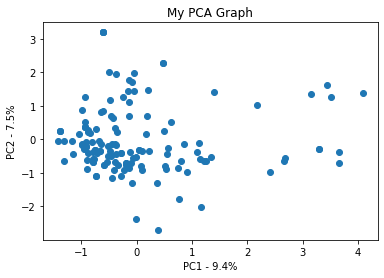

In [65]:
plt.scatter(phonemes_pca.PC1, phonemes_pca.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

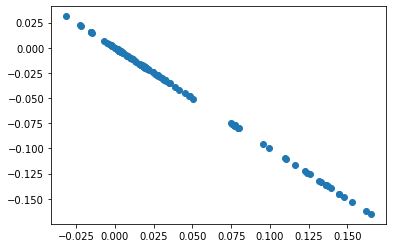

In [72]:
plt.scatter(mtx2[0], mtx2[1])

In [73]:
coordinates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
0,34.79905,35.46569,20.09317,22.80561,-15.72997,-4.39617,10.59519,13.24224,15.25689,18.50315,-1.24507,-2.14758,5.54402,7.00147,4.40609,7.16637,10.85543,11.58374,11.58374,11.58374,9.81700,10.55475,11.08465,11.68053,11.69175,11.84674,11.84674,11.84674,9.84015,9.84015,36.81015,33.17731,34.75535,14.91563,34.76550,29.95202,22.2616,29.88434,27.14538,12.74029,...,98.47395,101.02027,104.38105,121.35791,121.35779,149.64936,150.81263,150.81263,151.48012,152.10698,152.10698,150.83295,155.00022,187.59396,200.22870,145.23969,151.70877,151.70877,151.70877,155.59643,155.10199,249.09584,279.87877,264.51130,270.85215,269.02569,251.67406,276.60643,278.14688,286.35628,282.85526,283.12899,283.26516,285.69226,291.76877,289.16259,289.16259,304.99092,287.72498,308.63847
1,-3.47684,-5.28543,-19.76648,-17.99140,13.42414,9.24792,7.86705,6.75852,5.95025,4.39102,6.53399,7.52679,9.24149,10.43425,7.79927,7.33054,5.58897,5.85445,5.85445,5.85445,2.23311,4.67242,4.73059,3.24147,3.22227,1.61921,1.61921,1.61921,1.77177,1.77177,-0.53321,-3.06169,-5.05235,-5.17078,0.77072,-2.00131,-6.0212,-22.69831,-31.80414,12.20530,...,19.52774,16.82773,12.44095,24.02603,23.36496,-5.59138,-5.50082,-5.50082,-5.42555,-4.31779,-4.31779,-2.73190,-5.68670,-13.67570,-21.22769,-6.49895,-4.41125,-4.41125,-4.41125,-6.34808,-5.94739,56.00635,44.86854,16.92452,19.70795,14.74326,28.65410,9.64125,8.67031,10.69529,6.78168,4.61412,1.45033,-13.83864,-17.68365,-3.95938,-3.95938,-22.86499,11.59319,-25.40311
